In [2]:
import tensorflow as tf
import pathlib, glob, re
%pylab inline
tf.enable_eager_execution()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [14]:
BATCH_SIZE = 32

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [256, 256])
  image /= 255.0
  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def classname_from_path(path):
    return re.search(r'.*/(?P<dir>[a-z _]*)/[0-9]*\.jpg', path).group('dir')

def classname_from_class_path(path):
    return re.search(r'.*/(?P<dir>[a-z _]*)/', path).group('dir')

def label_to_number(onehot):
    return np.nonzero(onehot.numpy())[0][0]

In [15]:
train_paths = []
test_paths = []
all_image_classnames = []
all_classes_paths = glob.glob('/home/datasets-local/places365/train/data_256/[w]/*/')

for class_path in all_classes_paths:
    classname = classname_from_class_path(class_path)
    all_image_classnames.append(classname)
    
    class_image_paths = glob.glob(class_path + '/*.jpg')
    images_in_class = len(class_image_paths)
    print("Class: %s, has %d images" % (classname, images_in_class))
    
    train_paths += class_image_paths[:images_in_class*3//4]
    test_paths += class_image_paths[images_in_class*3//4:]

Class: wind_farm, has 5000 images
Class: water_tower, has 5000 images
Class: waterfall, has 5000 images
Class: wheat_field, has 5000 images
Class: waiting_room, has 5000 images
Class: water_park, has 5000 images
Class: windmill, has 5000 images
Class: wet_bar, has 5000 images
Class: wave, has 5000 images
Class: watering_hole, has 5000 images


In [16]:
random.shuffle(train_paths)

In [17]:
CLASSES = len(set(all_image_classnames))
classname_dict = dict()

def get_labels(image_paths):
    labels = []
    for image_path in image_paths:
        classname = classname_from_path(image_path)
        if classname not in classname_dict:
            classname_dict[classname] = len(classname_dict)
        labels.append(tf.one_hot(classname_dict[classname], CLASSES))
    return labels

train_labels = get_labels(train_paths)
test_labels = get_labels(test_paths)

In [18]:
number_to_classname = ['' for _ in range(CLASSES)]
for k in classname_dict.keys():
    number_to_classname[classname_dict[k]] = k

Construct $all\_image\_labels$ and $label\_to\_classname$

In [19]:
print(train_labels[:5])
print(test_labels[:5])

[<tf.Tensor: id=250061, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=250066, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=250071, shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=250076, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=250081, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]
[<tf.Tensor: id=437561, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=437566, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=437571, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Tensor: id=437576,

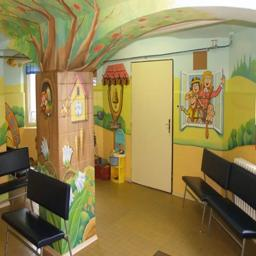

waiting_room


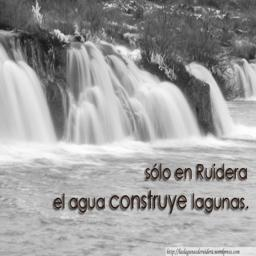

waterfall


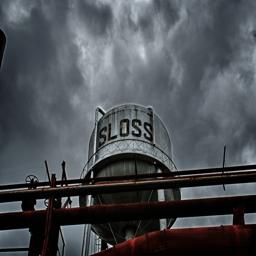

water_tower


In [20]:
from IPython.display import Image, display

for _ in range(3):
    x = np.random.randint(1, high=len(train_paths))
    display(Image(train_paths[x]))
    print(classname_from_path(train_paths[x]))

In [21]:
def load_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=64)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [22]:
train_ds = load_dataset(train_paths, train_labels)

In [23]:
test_ds = load_dataset(test_paths, test_labels)

# Model

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 3), filters=64, kernel_size=3, activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(CLASSES, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 14400)             0         
__________

In [40]:
model.fit(train_ds, epochs=10, steps_per_epoch=len(train_paths)//BATCH_SIZE)

Epoch 1/10
1171/1171 [==============================] - 98s 84ms/step - loss: 1.2337 - acc: 0.5774
Epoch 2/10
1171/1171 [==============================] - 98s 84ms/step - loss: 1.1075 - acc: 0.6257
Epoch 3/10
1171/1171 [==============================] - 98s 84ms/step - loss: 1.0591 - acc: 0.6450
Epoch 4/10
1171/1171 [==============================] - 98s 84ms/step - loss: 1.0082 - acc: 0.6652
Epoch 5/10
1171/1171 [==============================] - 98s 84ms/step - loss: 0.9905 - acc: 0.6744
Epoch 6/10
1171/1171 [==============================] - 98s 84ms/step - loss: 0.9602 - acc: 0.6841
Epoch 7/10
1171/1171 [==============================] - 98s 84ms/step - loss: 0.9582 - acc: 0.6890
Epoch 8/10
1171/1171 [==============================] - 98s 84ms/step - loss: 0.9638 - acc: 0.6896
Epoch 9/10
1171/1171 [==============================] - 98s 84ms/step - loss: 0.9790 - acc: 0.6859
Epoch 10/10
1171/1171 [==============================] - 98s 84ms/step - loss: 1.0131 - acc: 0.6786


# Testing and predicting

In [41]:
model.evaluate(test_ds, steps=len(test_paths)//BATCH_SIZE)

390/390 [==============================] - 28s 72ms/step - loss: 1.4253 - acc: 0.6179


[1.425322145691667, 0.6178686]

In [43]:
it = iter(test_ds)
cfm = np.zeros((10, 10))
for i in range(len(test_paths)//BATCH_SIZE):
    if i%50 == 0:
        print(i)
    data, target = next(it)
    pred = model.predict(data.numpy())
    for i in range(BATCH_SIZE):
        cfm[label_to_number(target[i])][np.argmax(pred[i])] += 1

0
50
100
150
200
250
300
350


In [46]:
cfm.astype(np.int32)
# (i, j) label i, predicted as j

array([[ 815,    9,   88,   30,  120,   23,   12,   67,   27,   59],
       [   9,  915,    3,    6,   30,  254,    4,   10,   18,    1],
       [ 196,   17,  481,   62,  187,   35,   16,  136,   92,   28],
       [  51,   17,   51,  589,  262,   35,   73,   26,   92,   34],
       [  97,    7,   29,   45,  989,   13,    9,    7,   25,   29],
       [   8,  265,   14,   18,   31,  812,    1,   34,   67,    0],
       [  20,    8,    0,  116,   93,    4,  946,   14,   29,   20],
       [ 177,   58,  180,   45,   69,   92,   27,  481,   98,   23],
       [   3,   16,   65,   29,   22,   29,   19,   31, 1031,    5],
       [ 154,    4,   63,  144,   43,   11,   42,   32,   98,  659]],
      dtype=int32)

In [47]:
number_to_classname

['wind_farm',
 'wet_bar',
 'windmill',
 'watering_hole',
 'wheat_field',
 'waiting_room',
 'waterfall',
 'water_tower',
 'water_park',
 'wave']